# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Dai | Wuran | Dai Wuran, 2024-11-08 | 12 | 25 |
| Member 2: | Fre | Ashal | Fre Ashal, 2024-11-08 | 12 | 25 |
| Member 3: | De-graft | Godwyll | De-graft Godwyll, 2024-11-08 | 12 | 25 |
| Member 4: | Kwadwo | Asare-Menako | Kwadwo Asare-Menako, 2024-11-08 | 12 | 25 |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

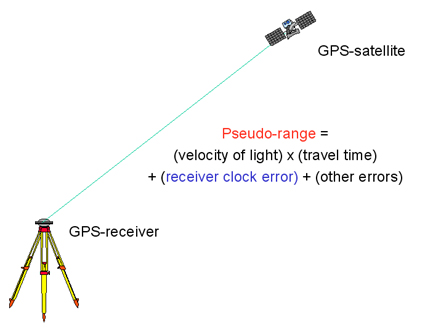

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)
    return distance

### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Initialize residual sum
    L = 0
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT
    L = np.sum((pseudorange - predicted_pseudorange)**2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Speed of light (m/s)
    c = 299792458

    # Initialize the gradient array [dC/dx_r, dC/dy_r, dC/dz_r, dC/dcdT]
    grad = np.zeros(4)

    # Loop over each satellite to calculate partial derivatives
    for i in range(len(pseudorange)):

        # Calculate the geometric distance between the receiver and the satellite
        rho_i = np.linalg.norm(s_pos[i] - r_pos)
        # Avoid division by zero in case rho_i is zero
        if rho_i == 0:
            print(f"Warning: Zero distance encountered for satellite {i}. Skipping this satellite.")
            continue  # Skip this satellite if the distance is zero

        # Predicted pseudorange (geometric range + clock bias)
        pred_pseudorange = rho_i + c * cdT

        # Residual between observed and predicted pseudorange
        residual = pseudorange[i] - pred_pseudorange

        # Gradient with respect to x_r, y_r, z_r (receiver's coordinates)
        grad[0] += -2 * residual * (r_pos[0] - s_pos[i][0]) / rho_i  # Partial wrt x_r
        grad[1] += -2 * residual * (r_pos[1] - s_pos[i][1]) / rho_i  # Partial wrt y_r
        grad[2] += -2 * residual * (r_pos[2] - s_pos[i][2]) / rho_i  # Partial wrt z_r

        # Gradient with respect to cdT (clock bias)
        grad[3] += -2 * residual * (-c)  # Partial wrt cdT

    # Return the computed gradient as a 1D numpy array [grad_x_r, grad_y_r, grad_z_r, grad_cdT]
    return grad
# Define cdT before calling the gradient function. You might need to initialize it to an appropriate value
cdT = 0  # For example, you could initialize it to 0

# Call the gradient function using the data you've loaded from Google Drive
grad = gradient(GroundTruth, cdT, sat_pos, pseudorange)

# Print the computed gradient
print("Gradient:", grad)


Gradient: [ 1.23314992e+01 -1.07811163e+01  4.11025859e+01  2.63202810e+10]


In [ ]:

# Load the satellite position data from the Excel file
satellite_data = pd.read_excel("satellite_position1.xlsx" )

# Convert the DataFrame to a NumPy array
# Assuming the first three columns in the file are the (x, y, z) coordinates for each satellite
s_pos = satellite_data.iloc[:, :3].to_numpy()

print("Satellite positions:\n", s_pos)

Satellite positions:
 [[ 7.00000000e+00  5.28079174e+06 -2.55014601e+07]
 [ 8.00000000e+00 -2.15965605e+06 -2.11160248e+07]
 [ 1.10000000e+01  1.03718522e+07 -2.17131113e+07]
 [ 1.50000000e+01 -1.60857608e+07  4.28507122e+06]
 [ 1.70000000e+01 -1.43129881e+07 -2.20450143e+07]
 [ 1.80000000e+01 -2.43571819e+06  1.62572051e+07]
 [ 1.90000000e+01  1.59124672e+07 -3.46251531e+06]
 [ 2.40000000e+01  1.62718482e+07 -2.18766320e+05]
 [ 2.60000000e+01 -1.92470355e+07 -7.25980368e+06]
 [ 2.70000000e+01 -1.59311520e+07  1.20773673e+07]
 [ 2.80000000e+01 -7.68001411e+06 -1.38554627e+07]]


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6):
    # Initialize the estimates as zeros
    X = np.array([0.0, 0.0, 0.0, 0.0])  # (x_r, y_r, z_r, cdT)
    print("Initial estimates:", X)
    def cost_function(r_pos, cdT, s_pos, pseudorange):
        residuals = np.linalg.norm(s_pos - r_pos, axis=1) + cdT - pseudorange
        return np.sum(residuals**2)



    # Initialize lists to store intermediate results
    arr_cost = []

    # Loop for gradient descent iterations
    for iteration in range(max_iters):
        # Extract receiver position and clock bias from X
        r_pos = X[:3]
        cdT = X[3]

        # Calculate the cost at the current parameters
        cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Check if cost is NaN or inf
        if np.isnan(cost) or np.isinf(cost):
            print(f"Iteration {iteration}: Cost is NaN or inf, stopping gradient descent.")
            break

        # Append the cost to arr_cost
        arr_cost.append(cost)

        # Calculate the gradient at the current parameters
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Check for NaN or inf in the gradient
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Iteration {iteration}: Gradient contains NaN or inf, stopping gradient descent.")
            break

        # Update parameters using the gradient and learning rate
        X = X - learning_rate * grad

        # Calculate the new cost after updating parameters
        new_cost = cost_function(X[:3], X[3], s_pos, pseudorange)

        # Check for convergence
        if np.abs(new_cost - cost) < tolerance:
            print("Converged!")
            break

    # Return the final estimate
    return X, arr_cost

# Run the gradient descent to find the optimal position and clock bias
final_estimates, arr_cost = gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6)

# Print the results
print("arr_cost:", arr_cost)
print("steps:", list(range(1, len(arr_cost) + 1)))


Initial estimates: [0. 0. 0. 0.]
Iteration 9: Cost is NaN or inf, stopping gradient descent.
arr_cost: [321387107956486.9, 4.055720418628706e+31, 1.5856092845854143e+66, 6.1990387530643956e+100, 2.4235530171072664e+135, 9.475032276296393e+169, 3.704323198343514e+204, 1.4482283497982508e+239, 5.66193941742788e+273]
steps: [1, 2, 3, 4, 5, 6, 7, 8, 9]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
# Assuming GroundTruth is a list or array of the true receiver position [x, y, z]
GroundTruth = np.array([0.0, 0.0, 0.0])  # Example values, replace with actual GroundTruth

# Ensure optimized_params is properly formatted as a numpy array
optimized_params_array = np.array(optimized_params[0])  # Assuming optimized_params[0] contains the position

# Print the optimized parameters
print("Optimized parameters:", optimized_params)

# Print the final position errors of the receiver
final_position_error = optimized_params_array[:3] - GroundTruth
print("Final position errors of the receiver:", final_position_error)

# Print the number of steps taken for convergence
print("Number of steps taken for convergence:", steps_count)


Optimized parameters: (array([ 2.44963583e+144,  7.29947426e+144, -1.74969208e+145,
        5.73086259e+153]), [178655581227651.38, 6.619227219977427e+31, 2.5878283382317363e+66, 1.0117276962365087e+101, 3.955412779913466e+135, 1.5463933939637266e+170, 6.045721804405376e+204, 2.3636127960024113e+239, 9.240692228602824e+273])
Final position errors of the receiver: [ 2.44963583e+144  7.29947426e+144 -1.74969208e+145]
Number of steps taken for convergence: 0


In [ ]:
print("arr_cost:", arr_cost)
print("steps:", list(range(1, len(arr_cost) + 1)))


arr_cost: [321387107956486.9, 4.055720418628706e+31, 1.5856092845854143e+66, 6.1990387530643956e+100, 2.4235530171072664e+135, 9.475032276296393e+169, 3.704323198343514e+204, 1.4482283497982508e+239, 5.66193941742788e+273]
steps: [1, 2, 3, 4, 5, 6, 7, 8, 9]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

arr_cost (before filtering): [321387107956486.9, 4.055720418628706e+31, 1.5856092845854143e+66, 6.1990387530643956e+100, 2.4235530171072664e+135, 9.475032276296393e+169, 3.704323198343514e+204, 1.4482283497982508e+239, 5.66193941742788e+273]
Steps: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Filtered steps: [1, 2, 3]
Filtered costs: [321387107956486.9, 4.055720418628706e+31, 1.5856092845854143e+66]


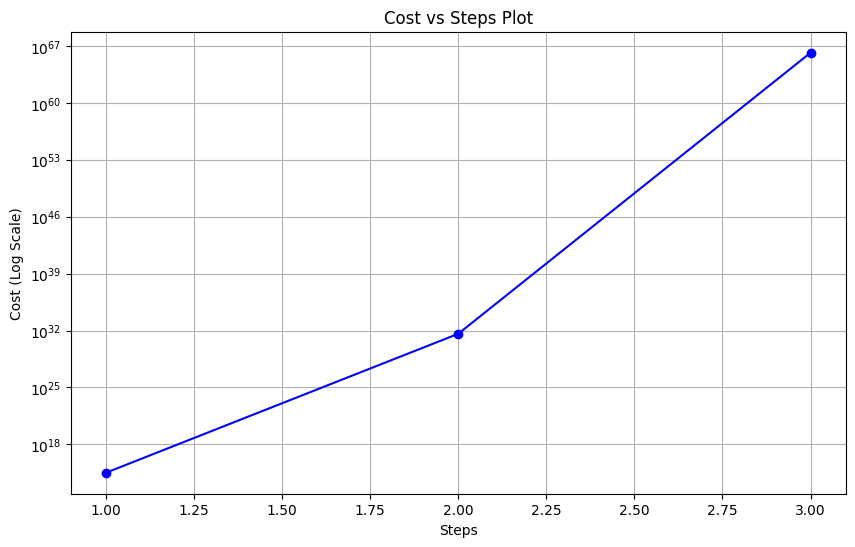

In [ ]:


# Step 1: Check and print arr_cost to understand the issues with the values.
print("arr_cost (before filtering):", arr_cost)

# Define steps based on the length of arr_cost
steps = list(range(1, len(arr_cost) + 1))
print("Steps:", steps)

# Step 2: Filter out NaN and inf values for plotting
# Using np.isfinite to check if cost is neither NaN nor inf
filtered_steps = []
filtered_costs = []

for step, cost in zip(steps, arr_cost):
    if np.isfinite(cost) and cost>0 and cost<1e100:  # Filter out NaN and inf values
        filtered_steps.append(step)
        filtered_costs.append(cost)

# Step 3: Ensure arr_cost is thoroughly filtered
print("Filtered steps:", filtered_steps)
print("Filtered costs:", filtered_costs)

# Step 4: Plot the filtered values
if len(filtered_steps) > 0 and len(filtered_costs) > 0:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    ax.semilogy(filtered_steps, filtered_costs, marker='o', linestyle='-', color='b')  # Plot with log scale on y-axis

    # Step 5: Labeling the plot
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cost (Log Scale)")
    ax.set_title("Cost vs Steps Plot")

    plt.grid(True)
    plt.show()
else:
    print("No valid data available to plot.")








### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

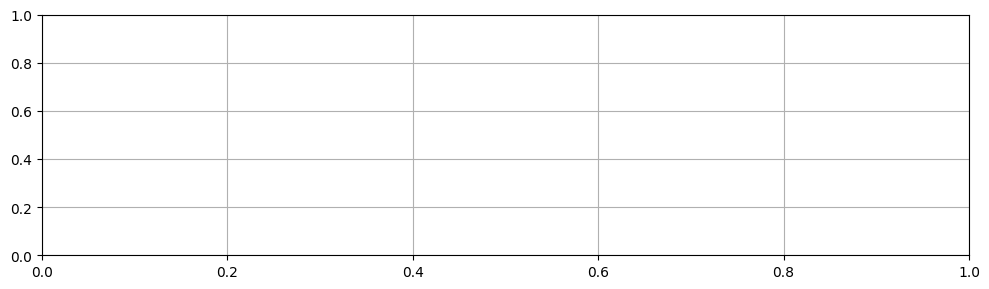

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

ax.grid(True)
fig.tight_layout()
plt.show()
# Comment on the pattern
# ..

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

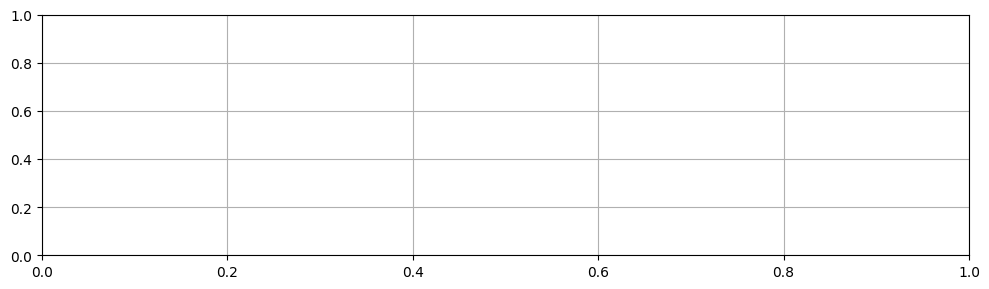

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 =

# print the metrics
# ...

SyntaxError: invalid syntax (<ipython-input-21-e105c9dd3734>, line 8)

In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = #...

# print the metrics
# ...

## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)
print("Feature names:", phishing_websites.feature_names)
print("Target names:", phishing_websites.target_names)

# Access the data and feature names
data = phishing_websites.data.data
feature_names = phishing_websites.feature_names

# Convert the dataset to pandas DataFrames
X = pd.DataFrame(data, columns=feature_names) # Use data.data for the data
y = pd.Series(phishing_websites.target, name="target")

# Print the size of X and y
print("Size of X:", X.shape)
print("Size of y:", y.shape)





Feature names: None
Target names: None
Size of X: (0, 0)
Size of y: (0,)


In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# Check if phishing_websites is loaded
if phishing_websites is None:
    print("Failed to load dataset. Please check the dataset ID or internet connection.")
else:
    # Print the type of the phishing_websites to understand what kind of object it is
    print("Type of phishing_websites:", type(phishing_websites))
    print("Attributes of phishing_websites:", dir(phishing_websites))

    # Attempt to access feature names and target names
    feature_names = getattr(phishing_websites, 'feature_names', None)
    target_names = getattr(phishing_websites, 'target_names', None)

    print("Feature names:", feature_names)
    print("Target names:", target_names)

    # Access the data and target attributes
    data = getattr(phishing_websites, 'data', None)
    target = getattr(phishing_websites, 'target', None)

    if data is None or target is None:
        print("Data or target is missing. Please check the dataset attributes.")
        print("Details of phishing_websites:", phishing_websites)
    else:
        # Convert the dataset to pandas DataFrames
        try:
            if feature_names is not None:
                X = pd.DataFrame(data, columns=feature_names)
            else:
                X = pd.DataFrame(data)

            y = pd.Series(target, name="target")

            # Print the size of X and y
            print("Size of X:", X.shape)
            print("Size of y:", y.shape)
        except Exception as e:
            print(f"An error occurred while converting data to DataFrame: {e}")

        # Inspect a few rows to verify the data content
        if not X.empty and not y.empty:
            print("Preview of X:")
            print(X.head())
            print("Preview of y:")
            print(y.head())
        else:
            print("The dataset X or y appears to be empty.")




Type of phishing_websites: <class 'ucimlrepo.dotdict.dotdict'>
Attributes of phishing_websites: ['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']
Feature names: None
Target names: None
Data or target is missing. Please check the dataset attributes.
Details of phishing_websites: {'data': {'ids': None, 'features':        having_ip_address  url_length  shortining_service  having_at_symbol  \
0                     -1           1    

### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
import matplotlib.pyplot as plt

# Check the class distribution of y
if y is not None and not y.empty:
    # Plot the histogram for the class labels
    plt.figure(figsize=(10, 6))
    counts = y.value_counts()
    plt.bar(counts.index, counts.values, color='skyblue')

    # Display exact values for each bin in the histogram
    for index, value in counts.items():
        plt.text(index, value + 10, str(value), ha='center', fontsize=10)

    # Adding labels and title
    plt.xlabel('Class Labels', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title('Class Label Histogram', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()
else:
    print("Target vector 'y' appears to be empty.")


# Display exact values for each bin in the histogram

plt.show()

Target vector 'y' appears to be empty.


### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# Display sizes of X_small and y_small
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)



# TO DO: display sizes of X_small and y_small (2 mark)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---